This task uses GREG Bigbin as database.
At first, we still need to start neo4j/GREG, if you don't know how to do it, please refer to [my workshop2 about graph Algorithms](https://nbviewer.jupyter.org/github/xiaowei3223/GREGgraphAlgorithms/blob/master/workshop2/GREG_Algorithms.ipynb) to learn for start neo4j/GREG.

[1. Number of nodes of each type (TF, chr1, etc)](#1)

[2. Number of relationships of each type (bind, etc)](#2)

[3. List of hubs for chr12 (a hub is a node with a high degree)](#3)

[4. Degree distribution for chr12 (GREG-min)](#4)

[5. Modules for chromosome 12](#5)

[6. Annotate all modules with the genes they contain in their bins](#6)

Now, we use `RNeo4j` package to get all the results of the task.

In [3]:
#connect neo4j with RNeo4j
library(RNeo4j)

graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")

<h1 id='1'>1. Number of nodes of each type (TF, chr1, etc)<h1>

In [4]:
query = "MATCH (n) RETURN distinct labels(n), count(labels(n)) as count"
labels <- cypher(graph,query)

In [5]:
labels

labels(n),count(labels(n))
<chr>,<int>
chr1,1245
chr2,1211
chr3,992
chr4,951
chr5,908
chr6,854
chr7,797
chr8,726
chr9,692


In [ ]:
write.csv(labels, file = "labels.csv", sep=",",quote = F, col.names = TRUE, row.names = FALSE)

<h1 id='2'>2. Number of relationships of each type (bind, etc)<h1>

In [8]:
query = "MATCH ()-[r]->() RETURN type(r), count(*) as count;"
relationshipType <- RNeo4j::cypher(graph,query)

In [9]:
relationshipType

type(r),count
<chr>,<int>
Bind,2372086
Interaction,1781980
Inclusion,1322494


<h1 id='3'>3. List of hubs for chr12 (a hub is a node with a high degree)<h1>

In [30]:
query = "
CALL algo.degree.stream(
  'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
  'Bind | Interaction',
  {direction: 'both'})
YIELD nodeId, score
with algo.asNode(nodeId).Name AS chr12_And_rel, score
MATCH (chr12:chr12)
where chr12.Name = chr12_And_rel and score > 0
RETURN chr12.Name AS Name, score as degree
ORDER By score DESC
"
chr12_hubs <- cypher(graph, query)

In [31]:
head(chr12_hubs)

Name,degree
<chr>,<dbl>
Bin314,780
Bin321,700
Bin175,697
Bin344,687
Bin247,678
Bin428,674


In [32]:
dim(chr12_hubs)

[1] 12167     2

In [ ]:
write.table(chr12_hubs, file = "chr12_hubs.csv",sep=",",quote = F, col.names = TRUE, row.names = FALSE)

<h1 id='4'>4. Degree distribution for chr12 <h1>

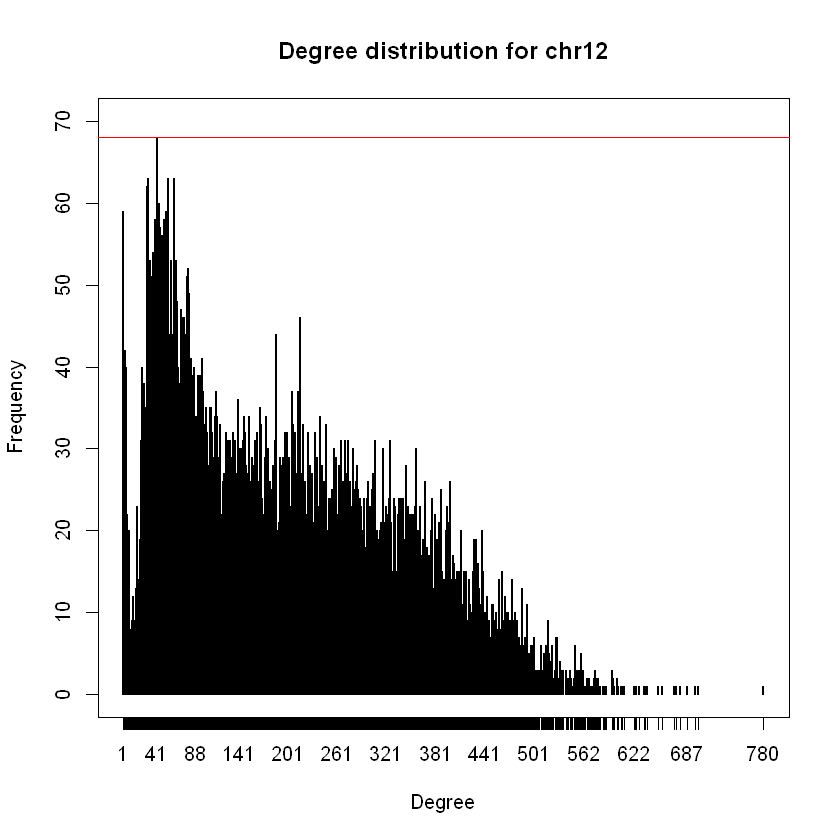

In [36]:
distribution <- table(chr12_hubs$degree)
plot(distribution,
     #xlim = c(0,500),
     ylim = c(0,70),
     xlab = "Degree", 
     ylab = "Frequency",
     main = "Degree distribution for chr12")

abline(h=max(distribution), col="red")

In [37]:
max(distribution)

[1] 68

In [38]:
median(distribution)

[1] 20

<h1 id='5'>5. Modules for chromosome 12<h1>

In [ ]:
# To know the numbers of modules ----------------
query = "CALL algo.louvain(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
        YIELD nodes, communityCount"
cypher(graph, query)  #Results： nodes:1288086 communityCount:23929

In [39]:
query = "
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
RETURN collect(algo.asNode(nodeId).Name) AS　Name, community
ORDER BY size(Name) DESC
"
module_chr12_total = cypher(graph, query) 

In [ ]:
write.table(module_chr12_total,file = "module_chr12_total.csv",sep=",",quote = F, col.names = TRUE, row.names = FALSE)

<h1 id='6'>6. Annotate all modules with the genes they contain in their bins<h1>

In [40]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
with algo.asNode(nodeId).Details AS　Details, community

// filter the number of community(Details) > 1 and split details
//where size(Details) > 1 
with split(Details, ';') as ann, community

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with DISTINCT ann1 as ann1, community

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community

// And we can extract the text about real gene names
return distinct substring(genelist, 11) as genelist, community
"

module_chr12 = cypher(graph, query) 

In [41]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
          'MATCH (n:chr12)-[r]-(m) with {m,n} as chr12_And_rel',
          'Bind | Interaction',
          {direction: 'both'})
YIELD nodeId, community
with algo.asNode(nodeId).Details AS　Details, community

// filter the number of community(Details) > 1 and split details
//where size(Details) > 1 
with split(Details, ';') as ann, community

// then ann is list, we need unlist ann for strings search
UNWIND (ann) as ann1
with DISTINCT ann1 as ann1, community

// now we want to find out which one terms including gene_name in ann1
where ann1 contains 'gene_name'
with ann1 as genelist, community

// And we can extract the text about real gene names
return collect( distinct substring(genelist, 11) ) as genelist, community
"

module_chr12_list = RNeo4j::cypher(graph, query)

In [ ]:
write.table(module_chr12_list, file = "module_chr12_list.csv" ,sep=",",quote = F, col.names = TRUE, row.names = FALSE)